This notebook provides examples of analysis of resting fMRI. 

To grab the data, you should first do the following:

bash ~/fmri-analysis-vm/get_resting.sh

This will grab 4 sessions of resting data from ses-105, along with the field maps for this session.  These data have been motion-corrected to a common target so that they are aligned to one another. The motion parameter files are derived separately from each session, rather than using the common target.

Credit:
- nilearn examples: https://nilearn.github.io/auto_examples/04_manipulating_images/plot_nifti_simple.html#sphx-glr-auto-examples-04-manipulating-images-plot-nifti-simple-py


In [12]:
import os,glob
import nibabel
import numpy
import sklearn
import nilearn.input_data
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img
from nilearn.plotting import plot_stat_map, show
from nilearn.image import index_img,clean_img
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA

import sys
sys.path.append('/home/vagrant/fmri-analysis-vm/analysis/utils')
from compute_fd_dvars import compute_fd,compute_dvars

%matplotlib inline

Load the data, clean it, and compute a mask using the nilearn NiftiMasker function

In [59]:
rsfmri_basedir='/home/vagrant/data/ds031/sub-01/ses-105/mcflirt'
rsfmri_files=glob.glob(os.path.join(rsfmri_basedir,'sub*.nii.gz'))

rsfmri_files.sort()

# load the first image and create the masker object
rsfmri_img=nibabel.load(rsfmri_files[0])
masker= nilearn.input_data.NiftiMasker(mask_strategy='epi')
masker.fit(rsfmri_img)
mask_img = masker.mask_img_

rsfmri={}  # nifti handle to cleaned image
fmri_masked=None
# load and clean each image
for f in rsfmri_files:
    rsfmri_img=nibabel.load(f)
    runnum=int(f.split('_')[3].split('-')[1])
    rsfmri[runnum]=nilearn.image.clean_img(rsfmri_img)
    print('loaded run',runnum)
    motparfile=f.replace('nii.gz','par')
    mp=numpy.loadtxt(motparfile)
    if fmri_masked is None:
        fmri_masked=masker.transform(rsfmri[runnum])
        motpars=mp
    else:
        fmri_masked=numpy.vstack((fmri_masked,masker.transform(rsfmri[runnum])))
        motpars=numpy.vstack((motpars,mp))


loaded run 1
loaded run 2
loaded run 3
loaded run 4


Visualize the mask

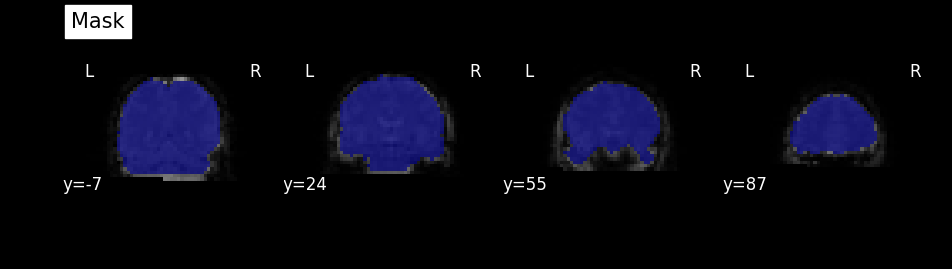

In [60]:
# calculate mean image for the background
mean_func_img = '/home/vagrant/data/ds031/sub-01/ses-105/mcflirt/mcflirt_target.nii.gz'

plot_roi(mask_img, mean_func_img, display_mode='y', 
         cut_coords=4, title="Mask")

Compute framewise displacement and plot it.

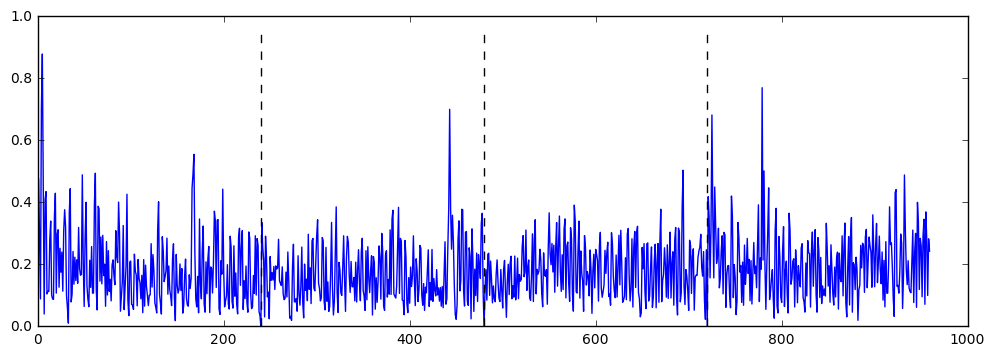

In [67]:
fd=compute_fd(motpars)
numpy.where(fd>1)
plt.figure(figsize=(12,4))
# remove first timepoint from each session
fd[240]=0
fd[480]=0
fd[720]=0
plt.plot(fd)
for c in [240,480,720]:
    plt.plot([c,c],
             [0,numpy.max(fd)*1.1],'k--')


Run ICA on the masked data, using the CanICA tool from nilearn.  Just arbitrarily set 10 components for now.

In [69]:
from nilearn.decomposition import CanICA

canica = CanICA(n_components=n_components, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(rsfmri_files)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)


[MultiNiftiMasker.fit] Loading data from [/home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-001_bold_mcf.nii.gz, /home/vagrant/data/ds031/sub-01/ses-105/mcflirt/sub-01_ses-105_task-rest_run-002_bold_mcf.nii.gz, /ho
[MultiNiftiMasker.fit] Computing mask
[Memory]    0.0s, 0.0min: Loading compute_multi_epi_mask from nilearn_cache/joblib/nilearn/masking/compute_multi_epi_mask/ae6e74c9990abc60822c4b443c4e6454
______________________________compute_multi_epi_mask cache loaded - 0.0s, 0.0min
[MultiNiftiMasker.transform] Resampling mask
[Memory]    0.0s, 0.0min: Loading resample_img from nilearn_cache/joblib/nilearn/image/resampling/resample_img/c136ecb36b63b74dc023722ba869e75b
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading filter_and_mask from nilearn_cache/joblib/nilearn/input_data/nifti_masker/filter_and_mask/12b980b302db1fa1774b2971dd047c61
_____________________________________filter_and_mask cach

/home/vagrant/miniconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


__________________________________________________________fastica - 5.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=398764591, fun='cube')
__________________________________________________________fastica - 4.5s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=924231285, fun='cube')


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=1478610112, fun='cube')


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s


__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=441365315, fun='cube')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s


__________________________________________________________fastica - 4.3s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=1537364731, fun='cube')


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s remaining:    0.0s


__________________________________________________________fastica - 4.5s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=192771779, fun='cube')


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.7s remaining:    0.0s


__________________________________________________________fastica - 4.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=1491434855, fun='cube')


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.3s remaining:    0.0s


__________________________________________________________fastica - 5.5s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=1819583497, fun='cube')


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   37.7s remaining:    0.0s


__________________________________________________________fastica - 5.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.008041, ..., -0.011671],
       ..., 
       [ 0.003736, ...,  0.009123]]), whiten=True, random_state=530702035, fun='cube')


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   42.9s remaining:    0.0s


__________________________________________________________fastica - 5.8s, 0.1min
[Memory]   52.3s, 0.9min: Loading unmask from nilearn_cache/joblib/nilearn/masking/unmask/a096eb942ca39afe26c2bcfd4ff8fde2
______________________________________________unmask cache loaded - 0.0s, 0.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   48.8s finished


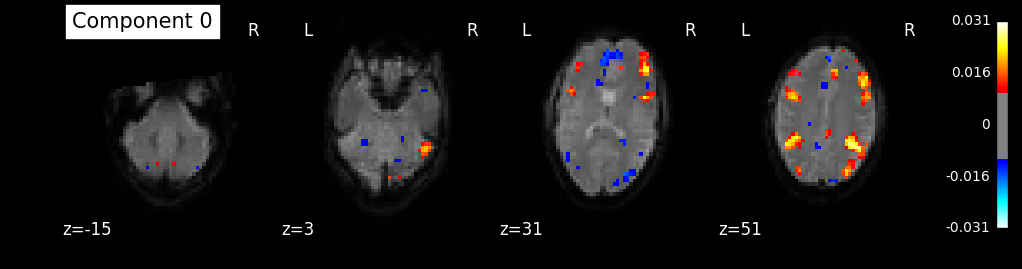

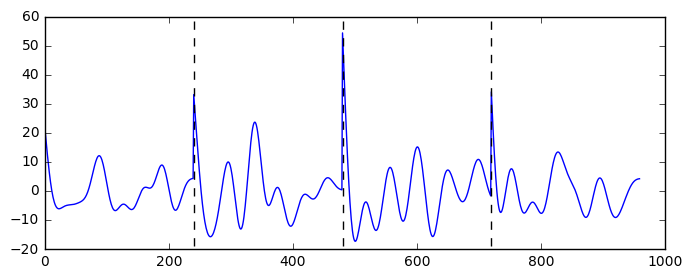

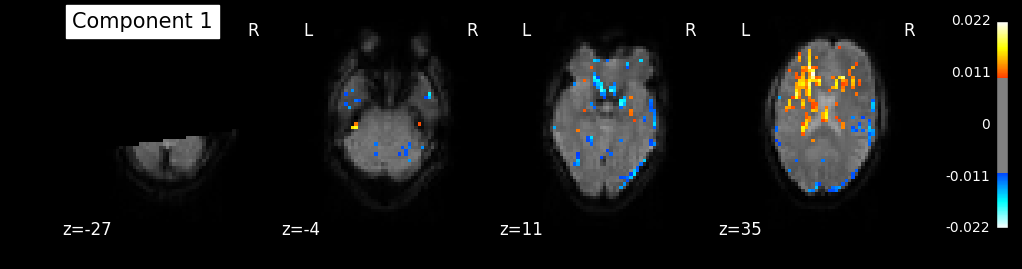

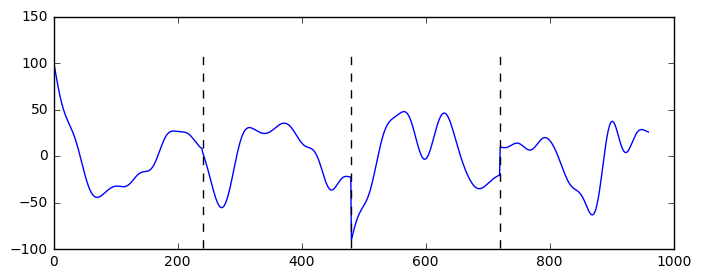

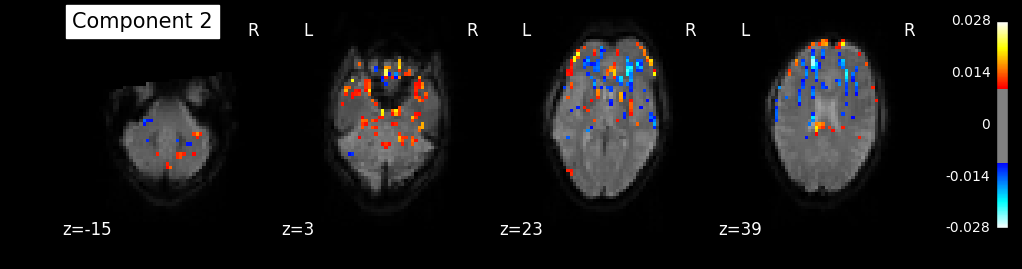

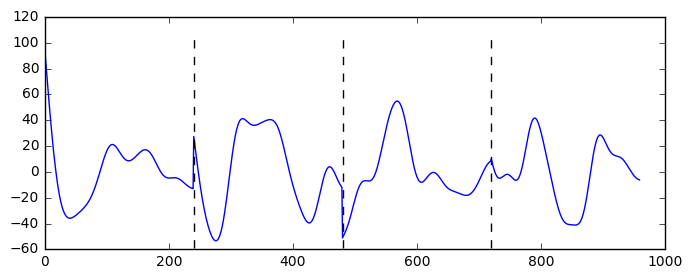

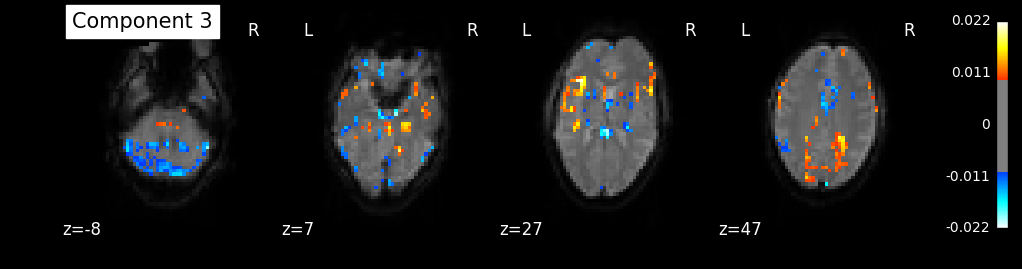

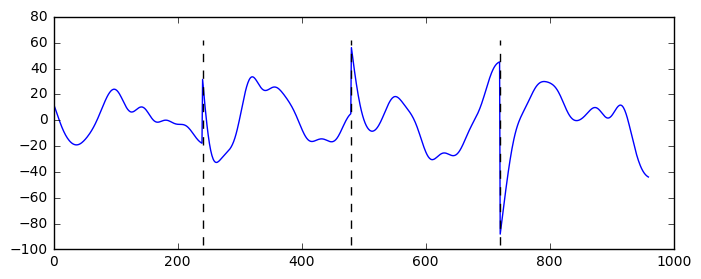

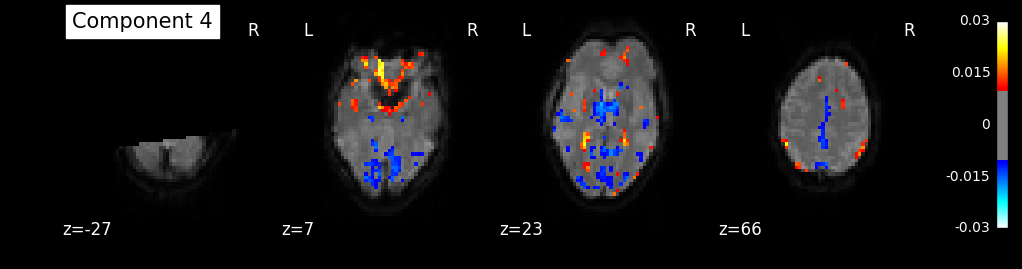

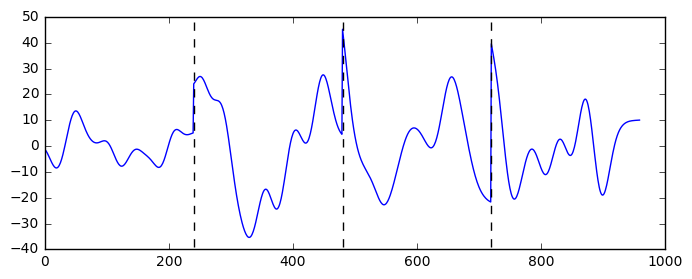

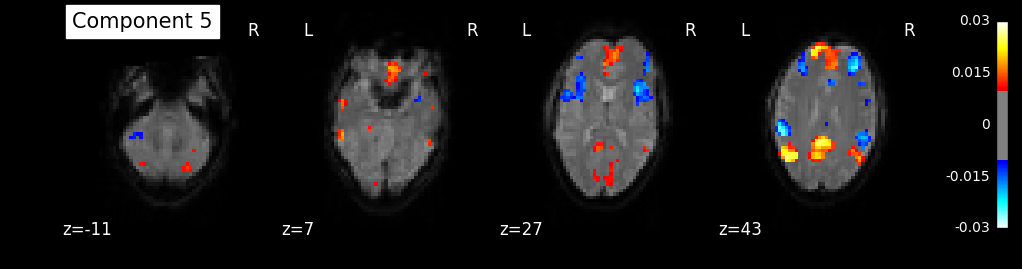

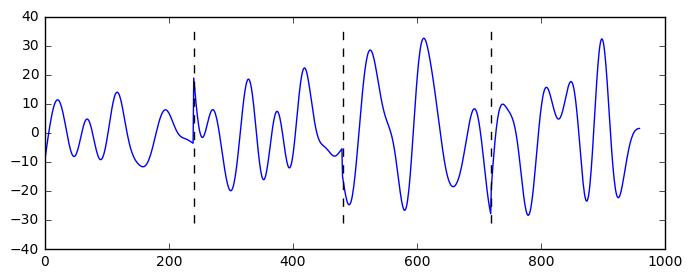

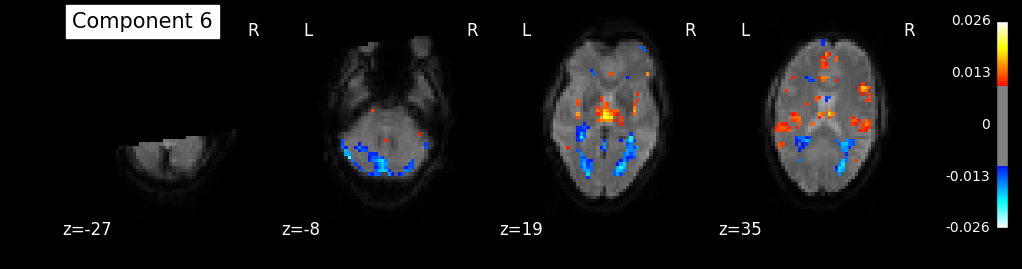

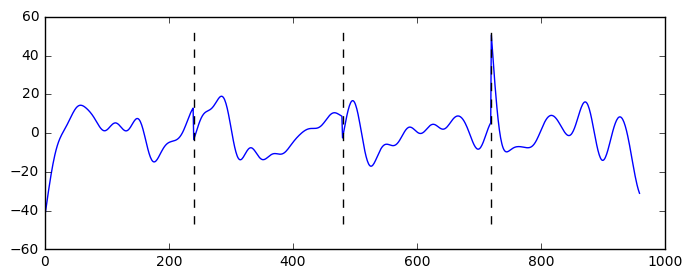

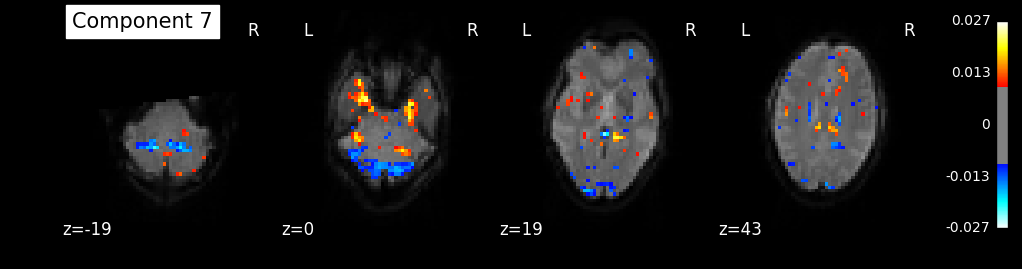

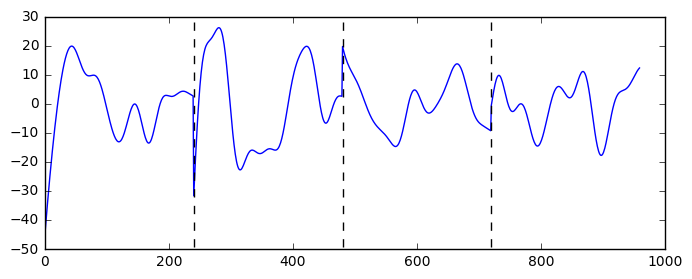

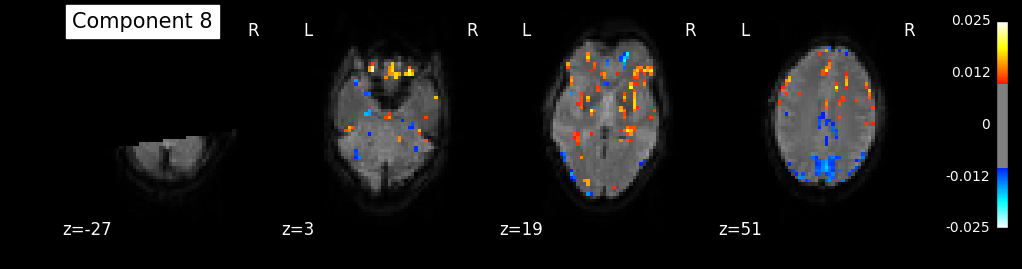

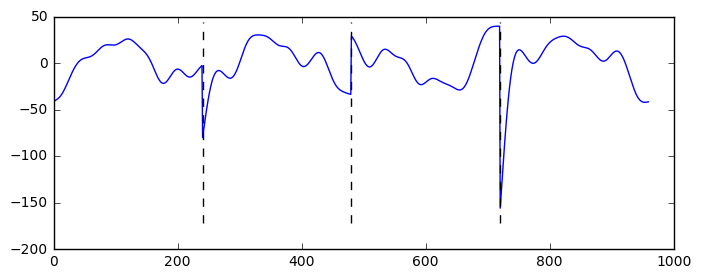

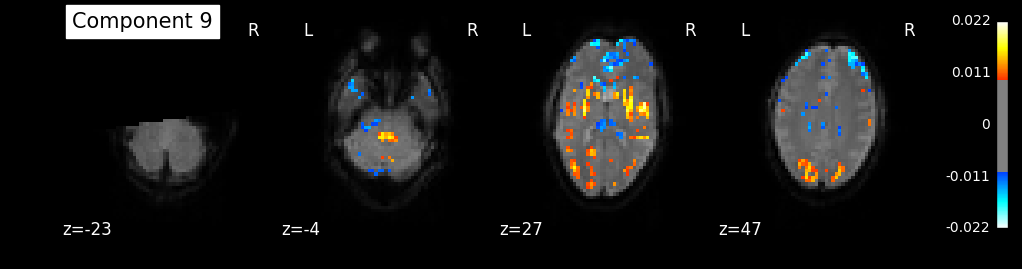

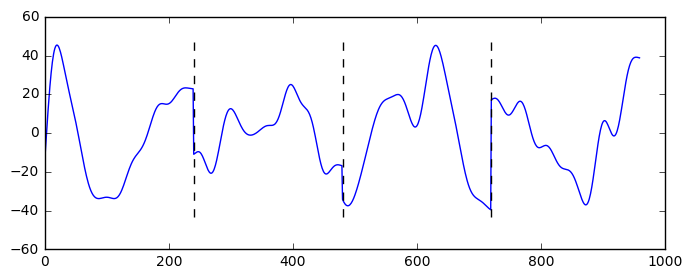

In [70]:
# Visualize results
for i in range(n_components):
    img=index_img(components_img, i)
    img_masked=masker.transform(img)
    ts=fmri_masked.dot(img_masked.T)
    plot_stat_map(img, mean_func_img,
              display_mode='z', cut_coords=4, threshold=0.01,
              title="Component %d"%i)
    plt.figure(figsize=(8,3))
    plt.plot(ts)
    for c in [240,480,720]:
        plt.plot([c,c],
                 [numpy.min(ts)*1.1,
                  numpy.max(ts)*1.1],
                'k--')

### Extracting a parcellated connectome

Next we will extract data from a set of atlas regions in order to calculate a connectome across regions.